<a href="https://colab.research.google.com/github/Britojuliano99/SIMULATION-OF-WORT-COLLING-/blob/main/final-rever-unidades.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install iapws

In [2]:
import iapws
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output as clear

In [3]:
class Transferencia() :
        K_aluminio=237
        g=9.81
        t=0
        dt=1
        laminar=False

        #iniciar o objeto
        def __init__(self,T_ambiente,T_mosto,T_entrada_fluido,m_mosto,D_in,D_out,L_tubo,L_panela,D_panela,Espessura_panela,m_dot,n):
                self.T_ambiente=T_ambiente
                self.T_mosto=T_mosto
                
                self.m_dot=m_dot
                self.m_mosto=m_mosto
                self.D_in=D_in
                self.D_out=D_out
                self.L_tubo=L_tubo
                self.L_panela=L_panela
                self.D_panela=D_panela
                self.Corda_panela=D_panela*np.pi
                self.Espessura_panela=Espessura_panela
                self.T_Parede_panela_interna=self.T_mosto
                self.T_Parede_panela_externa=self.T_ambiente
                self.T_saida_fluido=np.ones(n)*self.T_mosto-1
                self.AreaTuboin=(self.L_tubo*np.pi*(self.D_in**2)/4)/n
                self.AreaTuboOut=(self.L_tubo*np.pi*(self.D_out**2)/4)/n
                self.rtubo=np.log(self.D_out/self.D_in)/(2*np.pi*self.K_aluminio)
                self.Area_panela=self.D_panela*np.pi*self.L_panela
                self.rpanela=np.log((self.D_panela+2*self.Espessura_panela)/self.D_panela)/(2*np.pi*self.K_aluminio)
                self.n=n
                self.humidaderelativa=0.6
                # Do tubo iniciar como vetor
                self.T_entrada_fluido=np.ones(n+1)*T_entrada_fluido
                self.T_saida_fluido=np.ones(n)*self.T_mosto-1
                self.T_medio=np.ones(n)*(self.T_entrada_fluido[0]+self.T_saida_fluido[0])/2
                

                self.T_parede_tubo_in=np.ones(n)*self.T_medio
                self.T_parede_tubo_out=np.ones(n)*self.T_medio
                
                self.dtln=np.zeros(n)
                self.h_tubo_externo=np.zeros(n)
                self.h_tubo_in=np.zeros(n)

                self.Utubo=np.zeros(n)
                self.q_tubo=np.zeros(n)


        
        #informações de temperatura
        
            
        def info_Temperaturas(self):
            Tk=273
            print("Temperatura do ambiente",self.T_ambiente-Tk)
            print("Temperatura do mosto",self.T_mosto-Tk)
            print("Temperatura de entrada",self.T_entrada_fluido-Tk)
            print("Temperatura de saida",self.T_saida_fluido-Tk)
            print("Temperatura da parede da panela interna",self.T_Parede_panela_interna-Tk)
            print("Temperatura da parede da panela externa",self.T_Parede_panela_externa-Tk)
            print("Temperatura da parede do tubo interna",self.T_parede_tubo_in-Tk)
            print("Temperatura da parede do tubo externa",self.T_parede_tubo_out-Tk)
            print("Temperatura media do fluido",self.T_medio-Tk)
            print("Energia no mosto",self.Energia_mosto)
            
        
        def info_U(self):
            print("U panela",self.Upanela)
            print("U tubo",self.Utubo)
            print("U panela parte de baixo",self.hparte_inferior)
          

        def Calculo_temperatura(self):
            self.dtlnf()
            self.Utubof()
            self.Uparede_panela()
            self.info_Temperaturas()
            self.info_U()
        
        def infoInteração(self):
                #clear(wait=True)
                print(f"Minutos passados = {self.t/60}")
                self.info_Temperaturas()
                self.info_U()
                print(f"Transferencia pelo tubo :{sum(self.qs_tubo)} \n Transferencia pelo parede lateral :{sum(self.qs_panela)}\n Pela parte de baixo:{sum(self.qs_parte_inferior)}\n Pela parte de cima:{sum(self.qs_superior)}\n Pela evaporação: {sum(self.qs_evaporativo)} ")
                print("Transferencia Total :",sum([sum(self.qs_tubo),sum(self.qs_panela),sum(self.qs_parte_inferior),sum(self.qs_superior),sum(self.qs_evaporativo)]))
                print("Energia Transferida=",(self.Energia_inicial-self.Energia_mosto))

        #Equações para calcular taxa de transferencia de energia
        def h_parede_plana_arf(self):
            g=9.81
            Tf=(self.T_ambiente+self.T_Parede_panela_externa)/2
            Dt=abs(self.T_Parede_panela_externa-self.T_ambiente)
            Ar=iapws.humidAir.Air(T=Tf,P=0.1)
            nu=Ar.nu
            beta=Ar.alfav
            alpha=Ar.alfa
            k=Ar.k
            Pr=Ar.Prandt
            #print(Pr,"Pr ar")
            Ra=self.g*beta*Dt*(self.L_panela**3)/(nu*alpha)
            if Ra < 10**9:
                Nul=0.68 + (0.67*(Ra**(1/4))/(1 +((0.492/Pr)**(9/16)))**(4/9))
                #print("laminar")
            else:
                Nul=(0.825 + (0.387*(Ra**(1/6))/((1+(0.492/Pr)**(9/16))**(8/27))))**2
                #print("turbulento")
            self.h_parede_plana_ar=Nul*k/self.L_panela
            return 

        def h_parede_plana_aguaf(self):
                Tf=(self.T_Parede_panela_interna+self.T_mosto)/2
                Dt=abs(self.T_Parede_panela_interna-self.T_mosto)
                agua=iapws._iapws._Liquid(Tf, P=0.1)
                nu=agua["mu"]
                cp=agua["cp"]
                k=agua["k"]
                rho=agua['rho']
                beta=agua['alfav']
                alpha= k/(rho*cp)
                Pr = (nu*cp*1000)/k
                #print(Pr,"agua in mosto")
                Ra=self.g*beta*Dt*(self.L_panela**3)/(nu*alpha)
                if Ra < 10**9:
                    Nul=0.68 + (0.67*(Ra**(1/4))/(1 +((0.492/Pr)**(9/16)))**(4/9))
                    #print("laminar")
                else:
                    Nul=(0.825 + (0.387*(Ra**(1/6))/((1+(0.492/Pr)**(9/16))**(8/27))))**2
                    #print("turbulento")
                
                self.h_parede_plana_agua=Nul*k/self.L_panela
                return

        def h_tubo_internof(self,i):
            dc=0.2
           
            Tmedio=self.T_medio[i]
            Tparede=self.T_parede_tubo_in[i]
            agua=iapws._iapws._Liquid(Tmedio, P=0.1)
            aguas=iapws._iapws._Liquid(Tparede, P=0.1)
            cp=agua["cp"]
            k=agua['k']
            rho=agua['rho']
            mu=agua['mu']
            Pr = (mu*cp*1000)/k
            mus=aguas['mu']
            #print(Pr,"Tubo in")
            Re_in=(4*self.m_dot)/(mu*np.pi*self.D_in)
            Recritico=Re_in*(1+12*(self.D_in/dc)**(1/2))
            #print(Recritico)
            if Recritico>2300:
                Nu_in=0.023*(Re_in**(0.8))*(Pr**(0.4))
                self.h_tubo_in[i]=Nu_in*k/self.D_in
            else:
                a=1+(957*(dc/self.D_in))/(Re_in**2)*Pr
                b=1 + 0.477/Pr
                parte1=(3.66+4.343/a)**3
                parte2=1.158*(((Re_in*(self.D_in/dc)**(1/2)))/b)**(1.5)
                Nu_in=(parte1 +parte2)**(1/3)*(mu/mus)**(0.14)
                self.h_tubo_in[i]=Nu_in*k/self.D_in
                
                if self.laminar==False:
                  print("laminar")
                  self.laminar=True
        def h_tubo_externof(self,i):
            Tf=(self.T_parede_tubo_out[i]+self.T_mosto)/2
            if Tf>=380:
                Tf=380
            agua=iapws._iapws._Liquid(Tf, P=0.1)
            g=9.81
            cp=agua["cp"]
            k=agua['k']
            rho=agua['rho']
            mu=agua['mu']
            Pr = mu*cp*1000/k
            alfav=agua['alfav']
            v=agua['mu']/(rho)
            alpha= k/(rho*cp)
            #print(Pr,"Pr tubo out")
            Ra_out=(g*alfav*(abs(self.T_parede_tubo_out[i]-self.T_mosto))*self.D_out**3)/(v*alpha)
            a=0.387*(Ra_out**(1/6))
            b=(1+((0.559/Pr)**(9/16)))**(8/27)
            Nu_out=(0.6+a/b)**2
            self.h_tubo_externo[i]=Nu_out*k/self.D_out
        
        def h_parte_inferior(self):
            
            g=9.81
            Tf=(self.T_ambiente+self.T_Parede_panela_externa)/2
            Dt=abs(self.T_Parede_panela_externa-self.T_ambiente)
            L=(self.D_panela/4)
            A=np.pi*(self.D_panela**2)/4
            Ar=iapws.humidAir.Air(T=Tf,P=0.1)
            nu=Ar.nu
            beta=Ar.alfav
            alpha=Ar.alfa
            k=Ar.k
            #print(k)
            Pr=Ar.Prandt
            Ra=self.g*beta*Dt*(L**3)/(nu*alpha)
            Nu=0.27*Ra**(1/4)
            self.hparte_inferior=Nu*k/L
            
            self.q_parte_inferior=self.hparte_inferior*(Dt)*A
        def rho(self,T,C):
          yc=[ 1.41988755e-19,-1.15986383e-16 ,3.95275721e-14,-7.53916440e-12,
              9.00221375e-10,-7.07336438e-08 ,3.72217388e-06,-1.29481812e-04,
              2.88215736e-03,-3.62478801e-02 , 2.08657708e-01]
      
          Ar=iapws.humidAir.Air(T=T,P=0.1)

          Rho=Ar.rho + C*np.polyval(yc,T-273.15)
          return Rho,C*np.polyval(yc,T-273.15)
       
        def diff(self,T):
          T=T
          D=1.87 * 10**(-6) * T**(2.072)
          return D*1e-4
        def hvap(self,T):
          kc=[-1.23036176e-05,  3.80725615e-04, -2.35647112e+00,  2.50115498e+03]
          hvap=np.polyval(kc,T-273.15)
          return hvap
        def h_superior(self):
          Ts=self.T_mosto
          Tinf=self.T_ambiente
          As=np.pi*self.D_panela**2/4
          l=(self.D_panela/4)
          Tf=(Ts+Tinf)/2
          rhoS=self.rho(Ts,1)
          rhoinf=self.rho(Tinf,self.humidaderelativa)
          rhomedio=(rhoS[0]+rhoinf[0])/2
          print(rhomedio)
          ar=iapws.humidAir.Air(T=Tf,P=0.1)
          #Grashof number
          Gr=self.g*abs(rhoinf[0]-rhoS[0])*l**3/(rhomedio*ar.nu**2)
          print("Gr",Gr)
          #Difussivity
          Dab=self.diff(Tf) #ok
          #SC,Rac,NuC
          Sc=ar.nu/Dab
          RaC=Gr*ar.Prandt
          NuC=0.54*RaC**(1/4)
          hc=NuC*ar.k/l
          self.q_superior=hc*As*(Ts-Tinf)/1000
          Ram=Gr*Sc
          Shl=0.54*RaC**(1/4)
          hm=Shl*Dab/l
          na=hm*As*(rhoS[1]-rhoinf[1])
          self.q_evaporação=na*self.hvap(Tf)
          print("Dab",Dab)
          print("NA",na)
          print("Hm",hm)
          print("Shl",Shl)
          print("Rhos",rhoS,"Rhoinf",rhoinf)
          #print("Evaporação",self.q_evaporação)
          
        
        
        def Uparede_panela(self):
                Tsa1=300
                while(True):
                    self.h_parede_plana_arf()
                    self.h_parede_plana_aguaf()
                    self.Upanela = (1/self.h_parede_plana_ar+1/self.h_parede_plana_agua+self.rpanela)**(-1)
                    self.q_parede_panela=self.Upanela*abs(self.T_ambiente-self.T_mosto)*(self.Area_panela)
                    #print(self.area_lateral_panela())
                    #print(q)
                    if abs(Tsa1-self.T_Parede_panela_interna)>0.0001:
                        self.deltat1=self.q_parede_panela*(1/self.h_parede_plana_agua)
                        self.deltat2=self.q_parede_panela*(1/self.h_parede_plana_ar + self.rpanela)
                        self.T_Parede_panela_interna=self.T_mosto-self.deltat1
                        self.T_Parede_panela_externa=self.T_mosto-self.deltat2
                        Tsa1=self.T_Parede_panela_interna
                        Tsa2=self.T_Parede_panela_externa
                    else:
                        break   
        

        def Utubof(self,i):
            Tsa1=300
            while(True):
                    self.h_tubo_externof(i)
                    #print("ok")
                    self.h_tubo_internof(i)
                    self.Utubo[i] = (1/self.h_tubo_in[i]+1/self.h_tubo_externo[i]+self.rtubo)**(-1)
                    self.q_tubo[i]=self.Utubo[i]*self.dtln[i]*self.AreaTuboin
                    
                    if abs(Tsa1-self.T_parede_tubo_in[i])>0.001:
                        deltat1=self.q_tubo[i]*(1/self.h_tubo_in[i])
                        deltat2=self.q_tubo[i]*(1/self.h_tubo_in[i] + self.rtubo)
                        self.T_parede_tubo_in[i]=self.T_medio[i]-deltat1
                        self.T_parede_tubo_out[i]=self.T_medio[i]-deltat2
                        Tsa1=self.T_parede_tubo_in[i]
                        Tsa2=self.T_parede_tubo_out[i]
                    else:
                        break 
            
        
        def dtlnf(self):
            for i in range(0,self.n):
              self.T_medio[i]=(self.T_saida_fluido[i]+self.T_entrada_fluido[i])/2
              #print(self.T_medio[i])
              for j in range(0,2):
                agua=iapws._iapws._Liquid(self.T_medio[i], P=0.1)
                dtin=(self.T_mosto-self.T_entrada_fluido[i])
                dtout=(self.T_mosto-self.T_saida_fluido[i])
                self.dtln[i]=(dtout-dtin)/np.log((dtout/dtin))
                self.Utubof(i)
               
                U=self.Utubo[i]
                self.T_saida_fluido[i]=self.T_mosto -dtin*np.exp(-U *self.AreaTuboin/(self.m_dot*agua["cp"]))
                self.T_entrada_fluido[i+1]=self.T_saida_fluido[i]
                self.T_medio[i]=(self.T_entrada_fluido[i]+self.T_saida_fluido[i])/2
        
        
        
        def interações(self,tfinal):
            self.Ts_mosto=np.zeros(tfinal)
            self.qs_parte_inferior=np.zeros(tfinal)
            self.qs_panela=np.zeros(tfinal)
            self.qs_tubo=np.zeros(tfinal)
            self.qs_evaporativo=np.zeros(tfinal)
            self.qs_superior=np.zeros(tfinal)
            self.Ts_saida=np.zeros(tfinal)
            while(True):
                agua=iapws._iapws._Liquid(self.T_mosto, P=0.1)
                if self.t==0:
                    self.Energia_inicial=self.m_mosto*agua["u"]
                self.dtlnf()
                self.Uparede_panela()
                self.h_parte_inferior()
                self.h_superior()
                self.T_mosto=self.T_mosto-(self.q_parede_panela+sum(self.q_tubo)+self.q_parte_inferior)*self.dt/(self.m_mosto*agua["cp"])
                self.Energia_mosto=self.m_mosto*agua["u"]
                self.Ts_mosto[self.t]=self.T_mosto
                self.Ts_saida[self.t]=self.T_saida_fluido[self.n-1]
                self.qs_parte_inferior[self.t]=self.q_parte_inferior
                self.qs_panela[self.t]=self.q_parede_panela
                self.qs_tubo[self.t]=sum(self.q_tubo)
                self.qs_evaporativo[self.t]=self.q_evaporação
                self.qs_superior[self.t]=self.q_superior
                self.t=self.t+self.dt
                

                if self.t%60==0:
                    self.infoInteração()
                    
                if self.t==tfinal:
                    self.infoInteração()
                    
                    break
                if self.T_mosto<self.T_ambiente:
                    self.infoInteração()

                    break

            self.plotf()
        
        
        #Plot de algumas variaveis importantes
        def plotf(self):
            tempo=np.linspace(0,self.t/60,self.t)
            plt.plot(tempo[1:self.t],self.Ts_mosto[1:self.t],label="Temperatura do mosto")
            plt.plot(tempo[1:self.t],self.Ts_saida[1:self.t],label="Temperatura de saida")
            plt.legend()
            plt.figure()
            plt.plot(tempo[1:self.t],self.qs_parte_inferior[1:self.t],label="Qparte Inferior")
            plt.plot(tempo[1:self.t],self.qs_panela[1:self.t],label="Q Lateral da panela")
            plt.plot(tempo[1:self.t],self.qs_tubo[1:self.t],label="Q tubo")
            plt.plot(tempo[1:self.t],self.qs_superior[1:self.t],label="Q superior")
            plt.plot(tempo[1:self.t],self.qs_evaporativo[1:self.t],label="Q evaporativo")
            plt.legend()
            plt.show()
       

                
            


1.352803816702234
Gr 351418.28624531516
Dab 3.219249734824531e-05
NA 0.0001058154149415936
Hm 0.010335260270609234
Shl 12.03921075010887
Rhos (1.5286270884726612, 0.5947497421022206) Rhoinf (1.1769805449318067, 0.015380918101923423)
laminar
1.3509684727488527
Gr 348610.8000502134
Dab 3.2171430125148146e-05
NA 0.00010476893099078122
Hm 0.010307842048144864
Shl 12.01513502202919
Rhos (1.5249564005658987, 0.590545795802865) Rhoinf (1.1769805449318067, 0.015380918101923423)
nan
Gr nan
Dab nan
NA nan
Hm nan
Shl nan
Rhos (nan, nan) Rhoinf (1.1769805449318067, 0.015380918101923423)
Minutos passados = 0.05
Temperatura do ambiente 27
Temperatura do mosto nan
Temperatura de entrada [25. nan nan nan nan nan nan nan nan nan nan]
Temperatura de saida [nan nan nan nan nan nan nan nan nan nan]
Temperatura da parede da panela interna nan
Temperatura da parede da panela externa nan
Temperatura da parede do tubo interna [nan nan nan nan nan nan nan nan nan nan]
Temperatura da parede do tubo externa [nan

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:307: RuntimeWarning: invalid value encountered in log
/usr/local/lib/python3.7/dist-packages/scipy/optimize/minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


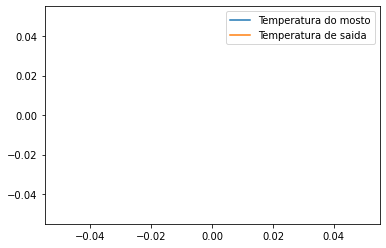

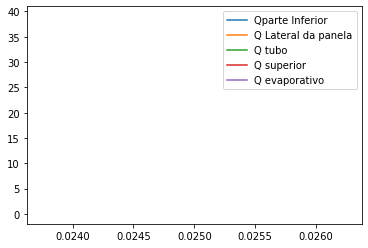

In [4]:
p=Transferencia(300,100+273,25+273,50,0.01,0.014,50,0.30,0.15,0.05,0.02,10)
p.interações(3)


1.352803816702234
Gr 351418.28624531516
Dab 3.219249734824531e-05
NA 0.0001058154149415936
Hm 0.010335260270609234
Shl 12.03921075010887
Rhos (1.5286270884726612, 0.5947497421022206) Rhoinf (1.1769805449318067, 0.015380918101923423)
1.3506384302683045
Gr 348104.58912104875
Dab 3.216762797092491e-05
NA 0.00010458084826357576
Hm 0.010302886779601362
Shl 12.010778493964972
Rhos (1.5242963156048024, 0.589789385595253) Rhoinf (1.1769805449318067, 0.015380918101923423)
1.3482624791937068
Gr 344448.1814458352
Dab 3.214013110423391e-05
NA 0.00010322777471307554
Hm 0.010266988041679389
Shl 11.979168669671616
Rhos (1.5195444134556069, 0.5843400989298921) Rhoinf (1.1769805449318067, 0.015380918101923423)
1.3459686335552479
Gr 340897.61580763996
Dab 3.211337168548487e-05
NA 0.00010192299186306052
Hm 0.010231946733426244
Shl 11.948231604622016
Rhos (1.514956722178689, 0.5790724277051931) Rhoinf (1.1769805449318067, 0.015380918101923423)
1.3436956755699674
Gr 337359.3257188401
Dab 3.208664460226916e

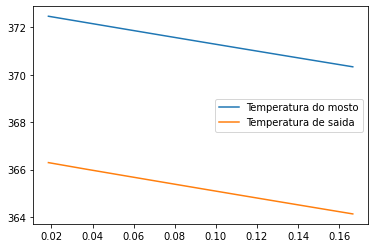

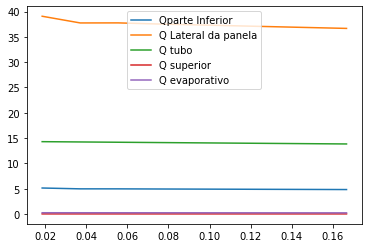

In [5]:
q=Transferencia(300,100+273,25+273,50,0.01,0.014,30,0.30,0.15,0.05,0.05,1)
q.interações(10)

In [6]:
def h_placasuperior(Ts,Tinf,Cinf):
  def rho(T,C):
    yc=[ 1.41988755e-19,-1.15986383e-16 ,3.95275721e-14,-7.53916440e-12,
    9.00221375e-10,-7.07336438e-08 ,3.72217388e-06,-1.29481812e-04,
    2.88215736e-03,-3.62478801e-02 , 2.08657708e-01]
      
    Ar=iapws.humidAir.Air(T=T+273.15,P=0.1)

    Rho=Ar.rho + C*np.polyval(yc,T)
    return Rho,C*np.polyval(yc,T)
  def diff(T):
    T=T+273.15
    D=1.87 * 10**(-6) * T**(2.072)
    return D*1e-4
  def hvap(T):
    kc=[-1.23036176e-05,  3.80725615e-04, -2.35647112e+00,  2.50115498e+03]
    hvap=np.polyval(kc,T)
    return hvap

  D=0.3
  g=9.81
  As=(0.25*0.5)
  P=np.pi*D 

  l=0.0833
  Tf=(Ts+Tinf)/2
  rhoS=rho(Ts,1)
  rhoinf=rho(Tinf,0.6)
  rhomedio=(rhoS[0]+rhoinf[0])/2
  Agua=iapws.iapws97.IAPWS97(P=0.1,T=Tf+273.15)
  ar=iapws.humidAir.Air(T=Tf+273.15,P=0.1)
  #Grashof number
  Gr=g*(rhoinf[0]-rhoS[0])*l**3/(rhomedio*ar.nu**2)
  #Difussivity
  Dab=diff(Tf)
  #SC,Rac,NuC
  Sc=ar.nu/Dab
  RaC=Gr*ar.Prandt
  NuC=0.54*RaC**(1/4)
  hc=NuC*ar.k/l
  qc=hc*As*(Ts-Tinf)/1000

  Ram=Gr*Sc
  Shl=0.54*RaC**(1/4)
  hm=Shl*Dab/l
  na=hm*As*(rhoS[1]-rhoinf[1])
  qe=na*hvap(Tf)
  Q=qe+qc
  return Q

In [7]:
   Agua.Vapor

NameError: ignored

In [ ]:

x=[30,31,32,33,34,35,36,38,40,45,50,55,60,65,70,75,80,85,90,95,100]
y=[2430.5,2428.1,2425.7,2423.4,2421.0,2418.6,2416.2,2411.5,2406.7,2394.8,2382.7,2370.7,2358.5,2346.2,2333.8,2321.4,2308.8,2296.0,2283.2,2270.2,2257.0]
x=np.array(x)
y=np.array(y)
Kc=np.polyfit(x,y,3)
xc=np.arange(30,100)
yc=np.polyval(Kc,xc)
plt.plot(xc,yc)
plt.plot(x,y)
Kc
def hvap(T):
  kc=[-1.23036176e-05,  3.80725615e-04, -2.35647112e+00,  2.50115498e+03]
  hvap=np.polyval(kc,T)
  return hvap

In [ ]:
def rho(T,C):
  yc=[ 1.41988755e-19,-1.15986383e-16 ,3.95275721e-14,-7.53916440e-12,
  9.00221375e-10,-7.07336438e-08 ,3.72217388e-06,-1.29481812e-04,
  2.88215736e-03,-3.62478801e-02 , 2.08657708e-01]
    
  Ar=iapws.humidAir.Air(T=T+273.15,P=0.1)

  Rho=Ar.rho + C*np.polyval(yc,T)
  return Rho



In [ ]:
rho(37,C=0.6)

In [ ]:
def h_convectivo_natural_superior(Tinf,Ts,D):
            As=np.pi*D**2/4
            P=np.pi*D
            l=As/P
            Tf=(Ts-Tinf)
            Ar=iapws.humidAir.Air(T=Tf+273.15,P=0.1)
            nu=Ar.nu
            g=9.81
            beta=Ar.alfav
            alpha=Ar.alfa
            k=Ar.k
            Pr=Ar.Prandt
            Ra=g*beta*Tf*(l**3)/(nu*alpha)
            if Ra > 10**4 and Ra <=10**7:
                Nu=0.54*Ra**(1/4)
            if Ra > 10**7 and Ra <10**9:
                Nu=0.15*Ra**(1/3)

In [ ]:
def h_convectivo_natural_superior(Tinf,Ts,D):
    As=np.pi*D**2/4
    P=np.pi*D
    l=As/P
    Tf=(Ts-Tinf)
    Ar=iapws.humidAir.Air(T=Tf+273.15,P=0.1)
    nu=Ar.nu
    g=9.8
    beta=Ar.alfav
    alpha=Ar.alfa
    k=Ar.k
    Pr=Ar.Prandt
    Ra=g*beta*Tf*(l**3)/(nu*alpha)
    if Ra > 10**4 and Ra <=10**7:
        Nu=0.54*Ra**(1/4)
    if Ra > 10**7 and Ra <10**9:
        Nu=0.15*Ra**(1/3)
    
    
   

    

In [ ]:

def hconvectivo_aquecimento_turbulento(Tm,m,D):
    Tm+=273.15
    cp=4180
    k=0.64
    pi=np.pi
    agua=iapws._iapws._Liquid(Tm, P=0.1)
    mu=agua["mu"]
    cp=agua["cp"]
    k=agua["k"]
    Re_in=(4*m)/(mu*pi*D)
    Pr = mu*cp/k  
    if Re_in >2300:
      Nu_in=0.023*(Re_in**(0.8))*(Pr**(0.4))
      h=Nu_in*k/D
      #print(Re_in)
    else:
      #print(Re_in)
      Nu_in=3.66
      h=Nu_in*k/D
    
    if h==np.NAN:
      print("erro em interno")
    return h  

In [ ]:

def hconvectivo_natural(D,Tinf,Ts):
    
    Tf=(Tinf+Ts)/2
    if Tf>=380:
        Tf=380
    agua=iapws._iapws._Liquid(Tf, P=0.1)
    g=9.81
    cp=agua["cp"]*1000
    k=agua['k']
    rho=agua['rho']
    mu=agua['mu']
    Pr = mu*cp/k
    alfav=agua['alfav']
    v=agua['mu']/(rho)
    alpha= k/(rho*cp)
    
    
    Ra_out=(g*alfav*(abs(Ts-Tinf))*D**3)/(v*alpha)
    a=0.387*(Ra_out**(1/6))
    b=(1+((0.559/Pr)**(9/16)))**(8/27)
    Nu_out=(0.6+a/b)**2
    h=Nu_out*k/D
    
  
    return h





In [ ]:
def hinterno(Tm,m,D,Ts):
    dc=0.2
    #propriedades
    #print(Ts,"ts")
    agua=iapws._iapws._Liquid(Tm, P=0.1)
    aguas=iapws._iapws._Liquid(Ts, P=0.1)
   
    cp=agua["cp"]*1000
    k=agua['k']
    rho=agua['rho']
    mu=agua['mu']
    Pr = (mu*cp)/k
    mus=aguas['mu']
    Re_in=(4*m)/(mu*np.pi*D)
  
    Recritico=2300*(1+12*(D/dc)**(1/2))
    if Re_in >Recritico:
      Nu_in=0.023*(Re_in**(0.8))*(Pr**(0.4))
      hin=Nu_in*k/D
    else:
        a=1+(957*(dc/D))/(Re_in**2)*Pr
        b=1 + 0.477/Pr
        parte1=(3.66+4.343/a)**3
        parte2=1.158*(((Re_in*(D/dc)**(1/2)))/b)**(1.5)
        Nu_in=(parte1 +parte2)**(1/3)*(mu/mus)**(0.14)
        hin=Nu_in*k/D

    return hin
    
    
    
    


In [ ]:
def ufunc(Tm,Tinf,m,d):
    Tm+=273.15
    Tinf+=273.15
    k_tubo=177
    t=0.001
    do=d+2*t
    Ts1=(Tm+Tinf)/2
    Ts2=Tinf
    Tsa1=Tm
    Tsa2=Tinf
    rtubo=2*np.pi*k_tubo/np.log(do/d)
    i=1
    while(True):
        hc=hinterno(Tm,m,d,Ts1)
        hh=hconvectivo_natural(do,Tinf,Ts2)
        
        if abs(Tsa1-Ts1)>0.0001:
            Tsa1=Ts1
            Tsa2=Tsa2
            U=1/(1/hh +rtubo +1/hc)
            q=U*(Tinf-Tm)
            deltat1=q*(1/hc)
            deltat2=q*(1/hc +rtubo)
            Ts1=Ts1+deltat1
            Ts2=Ts2+deltat2
            i=i+1
            #print(i)
            
        else:
            break
        

    #print(Ts1,"Tsi")
    #print(Ts2,"Tso")
    #print(hc,"hc")
    #print(hh,"hh")
    
    U=1/((1/hh) +(1/rtubo) +(1/hc))
    q=U*(Tinf-Tm)
    deltat=q*((1/hc)+rtubo)
    return U

In [ ]:
def ufunc2(Tmosto,Tinf,d):
    Tm+=273.15
    Tinf+=273.15
    k_tubo=177
    t=0.01
    do=d+2*t
    Ts1=(Tm+Tinf)/2
    Ts2=Tinf
    Tsa1=Tm
    Tsa2=Tinf
    rtubo=2*np.pi*k_tubo/np.log(do/d)
    i=1
    while(True):
        hc=
        hh=
        
        if abs(Tsa1-Ts1)>0.0001:
            Tsa1=Ts1
            Tsa2=Tsa2
            U=1/(1/hh +rtubo +1/hc)
            q=U*(Tinf-Tm)
            deltat1=q*(1/hc)
            deltat2=q*(1/hc +rtubo)
            Ts1=Ts1+deltat1
            Ts2=Ts2+deltat2
            i=i+1
            #print(i)
            
        else:
            break
        

    #print(Ts1,"Tsi")
    #print(Ts2,"Tso")
    #print(hc,"hc")
    #print(hh,"hh")
    
    U=1/((1/hh) +(1/rtubo) +(1/hc))
    q=U*(Tinf-Tm)
    deltat=q*((1/hc)+rtubo)
    return U

In [ ]:

def transf(m_dot,Tinfi,Tin,li,dinin,dt):
  din=dinin
  dout=din+0.01
  l=li
  cp=4180
  A=np.pi*din*l
  Touta=Tinfi-0.01
  m_mosto=50
  t=int(100000/dt)
  Tinf=Tinfi
  k_tubo=237
  Tinfs=np.zeros(t)
  Qs=np.zeros(t)
  Touts=np.zeros(t)
  Qsparede=np.zeros(t)
  Qstubo=np.zeros(t)
  j=0
  K=273.15
  rtubo=(((din/2)/k_tubo)*np.log(dout/din))
  Tambiente=28
  while True:
    #discretizar
    for i in range (0,200):
          dtin=(Tinf-Tin)
          dtout=(Tinf-Touta)
          dtinf=0.001
          dtln=(dtout-dtin)/np.log((dtout/dtin))
          dtlnmax=(dtinf-dtin)/np.log((dtinf/dtin))
          h_max=m_dot*cp/(np.pi*din*l) *(Tinf-Tin)/dtlnmax
          u=ufunc(Tm=Tin+dtln,Tinf=Tinf,m=m_dot,d=din)
          if u<h_max:
            U=u
            Tout_novo=Tin +(U*A*dtln)/(m_dot*cp)
            qtubo=(U*A*dtln)
          else:
            U=h_max
            Tout_novo=Tinf-dtinf
            qtubo=(U*A*dtlnmax)
          if  abs(Touta- Tout_novo)<(0.001):
            break
          else:
            Touta=Tout_novo
    qparede=q_parede_plana(Tambiente,Tinf,0.5,np.pi*0.25)
    dtinf=(qtubo+qparede)/(m_mosto*cp)
    Tinf=Tinf-dtinf*dt
    Tinfs[j]=Tinf
    Qs[j]=qtubo+qparede
    Qsparede[j]=qparede
    Qstubo[j]=qtubo
    Touts[j]=Tout_novo
    j+=1
    if round(Tinf)==30:
      jt=j
      Qs[j:]=U*A*dtln
      Tinfs[j:]=Tinf
      Touts[j:]=Tout_novo
      break
    if j ==t:
      jt=j
      break
  print(Tinf)
  print(jt*dt)
  print((jt*dt)*m_dot)
  return(Tinfs,Qs,Qsparede,Qstubo,Touts,int(jt))

In [ ]:
a=transf(0.01,98,25,30,0.13,1)
#b=transf(0.05,100,25,20,0.13,60)
    


In [ ]:
a[4]

In [ ]:
tempo=np.arange(0,10000,(0.1/1))
Tempsa=a[0]
Tempsa=Tempsa[:a[5]]
tempoa=tempo[:a[5]]
#Tempsb=b[0]
#Tempsb=Tempsb[:b[5]]
#tempob=tempo[:b[5]]
plt.plot(tempoa,Tempsa,label="a Tinf")
#plt.plot(tempob,Tempsb,label="b Tinf")
plt.legend()

Toutsa=a[4]
Toutsa=Toutsa[:a[5]]
#Toutsb=b[4]
#Toutsb=Toutsb[:b[5]]
plt.plot(tempoa,Toutsa,label="a Tsaida")
#plt.plot(tempob,Toutsb,label="b Tsaida")
plt.legend()
plt.show()


In [ ]:
qsa=a[1]
qsa=qsa[:a[5]]
qsaP=a[2]
qsaP=qsaP[:a[5]]
qsaT=a[3]
qsaT=qsaT[:a[5]]
plt.plot(tempoa,qsa,label="qtotal")
plt.plot(tempoa,qsaT,label="qtubo")
plt.plot(tempoa,qsaP,label="qparede")
plt.ylim((0,10000))
plt.legend()
plt.show()

In [ ]:
Parteparede=qsaP.sum()/qsa.sum()
Partetubo=qsaT.sum()/qsa.sum()

plt.bar(x="Tubo",height=Partetubo)
plt.bar(x="Parede",height=Parteparede)
plt.title("Porcentagem da transferencia de calor")


In [ ]:
Tempsa=a[1]
Tempsa=Tempsa[:a[5]]
#Tempsb=b[1]
#Tempsb=Tempsb[:b[2]]
plt.plot(Tempsa,label="a")
#plt.plot(Tempsb,label="b")
plt.legend()

In [ ]:
U=100
din=0.05
Tin=15
m_dot=0.05
cp=4180
Tout_i=57
l=10
A=2*np.pi*din*l
Tinf=100
dtin=(Tinf-Tin)
dtout=(Tinf-Tout_i)
dtln=(dtout-dtin)/np.log((dtout/dtin))

Tout_novo=Tin +(U*A*dtln)/(m_dot*cp)

hconvectivo_aquecimento_turbulento(Tin+dtln,m_dot,din)

In [ ]:
hconvectivo_natural(Tin+dtln,din,Tinf)